# DRP Detector New Model
## Preface
The goal of the project is to create a Machine Learning algorithm that can compare eye images and categorize if there are diseases present.

In this document I'll continue to work on creating a machine learning model that can accurately detect what category of DRP is present in the image. The diffrence with this document is that I'll be using evenly distributed categories.

Most of these use Fundus photography that are taken with a machine that is available in places other then hospitals. 
https://en.wikipedia.org/wiki/Fundus_photography

## Data set
The dataset used can be found here:

Dataset of eyes with and without Diabetische retinopathie.
https://www.kaggle.com/donkeys/retinopathy-train-2015?select=trainLabels.csv


### Research questions
For this I'll need be researching the following technical requirements:
- How do you ensure the quality of the model and evaluate the performance?
- How do you remove the bias from a biased dataset?

### On the  data set 

The dataset provides a large set of retina images taken using fundus photography under a variety of imaging conditions.

A clinician has rated each image for the severity of diabetic retinopathy(DRP) on a scale of 0 to 4:

0.  No DR
1.  Mild
2.  Moderate
3.  Severe
4.  Proliferative DR

## Importing libraries
Here I import a number of libraries required for creating the machine learning model:
- os/shutil: finding/loading/sorting the images
- matplotlib: Displaying the loaded images in a graph.
- pandas/numpy: math libraries with various datatypes and advanced functions used in calculations. also requirements for SKlearn to work.
- skimage: loading a list of images into an array
- sklearn: creating the machine learning model
- joblib: saving the model to a file for later use. prevents the retraining of models.

In [60]:
# File moving imports
import os
import shutil

# Standard scientific Python imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import datasets, classifiers and performance metrics
import skimage.io as io
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn import svm, metrics
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

#save model
from joblib import dump, load


## Sorting all images by category into folders 
Sort all images into diffrent folders based on category to remove bias in the data.

All images from the "DrpTest" folder are copied over and sorted into 5 diffrent folders inside the "Sorted" folder.

In [61]:
srcpath = "Data/DrpTest/"
newPath = 'Data/Sorted/'
limit = 250
useExistingModel = True

labels = pd.read_csv("Data/trainLabels.csv")
labels = labels.set_index('image')
# Delete old files from the sorted folder
oldFiles = os.listdir(newPath)
for file in oldFiles:
    os.remove(newPath + file)

#create a category img limit
# limitTracker = [-abs(limit*3),limit, limit,limit,-abs(limit*3)]
limitTracker = [0,0,0,0,0]
# create destination directories and store their names along with full paths
for filename in reversed(labels.index):
    filename = filename + '.png'
    fileCategory = labels.loc[(filename)[0:-4], 'level']
    if limitTracker[fileCategory] < limit:
        limitTracker[fileCategory]+=1
        oldFolder = srcpath + filename
        newFolder = newPath + str(labels.loc[(filename)[0:-4], 'level']) + '_' + filename
        shutil.copy(oldFolder, newFolder)
# note: might give keyerror if it reaches the labels.csv file

## Labels
Load the labels containing the DRP category of the images used while training the model.

The algorithm uses these labels to train the model.

In [62]:
labels = pd.read_csv("C:/Users/mauri/Documents/GitHub/EyeDiseaseDetection/Data/trainLabels.csv")

In [63]:
labelsIndexed = labels.set_index('image')
labelsIndexed.sample(10)

,level
image,
10772_right,0
22954_right,2
29050_left,0
38274_left,1
13410_right,0
20046_left,0
38758_right,0
19739_right,0
8403_right,1


### Sorting labels
Create diffrent label dataframes for each DRP category and link them back together to sort them.

This makes it so that the labels lign up with the new data folders createded.

In [64]:
# Sort labels by category, then take the first x images
imagesPerCategory = limit

SortedLabels = (labelsIndexed.loc[labelsIndexed['level']==0])[0:imagesPerCategory]
SortedLabels = SortedLabels.append((labelsIndexed.loc[labelsIndexed['level']==1])[0:imagesPerCategory])
SortedLabels = SortedLabels.append((labelsIndexed.loc[labelsIndexed['level']==2])[0:imagesPerCategory])
SortedLabels = SortedLabels.append((labelsIndexed.loc[labelsIndexed['level']==3])[0:imagesPerCategory])
SortedLabels = SortedLabels.append((labelsIndexed.loc[labelsIndexed['level']==4])[0:imagesPerCategory])
SortedLabels.head(limit+3)

,level
image,
10_left,0
10_right,0
13_left,0
13_right,0
17_left,0
...,...
386_left,0
386_right,0
15_left,1


In [65]:
# Turn the pandas dataframe into a numpy array that can be read by the model
label_list =(SortedLabels[['level']].values.flatten().tolist())
label_list = np.asarray(label_list)
# Convert the categories into a binary solutio
convertedLabelList = label_list
# convertedLabelList = np.where(label_list > 0, 4, label_list)
convertedLabelList

array([0, 0, 0, ..., 4, 4, 4])

Convert the numbers into readable words. This is make it easier for the stakeholder to understand of the results.

In [66]:
# Used in the evaluation section, translates the category number into readable text
label_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
label_names[label_list[1]]

'No DR'

## Model
### Loading the images
First, create 2 functions that load the images using a load function. This load funtion resizes all images to the same resolution and the 2nd one also greyscales them to remove a third demension from the array.

In [67]:
standerdImgHeight = 597
standerdImgWidth = 896

def transformImage(f, img_num=None):
        img = io.imread(f)
        im_res = resize(img,(standerdImgHeight, standerdImgWidth))
        return im_res

def transformImageFlat(f, img_num=None):
        img = io.imread(f)
        # im_res = resize(img,(597, 896))
        ## Turn images grey
        img_gray = rgb2gray(img)        
        im_res = resize(img_gray,(standerdImgHeight, standerdImgWidth))
        # Reshape 2d array into 1d array
        im_res = np.reshape(im_res, (standerdImgHeight*standerdImgWidth))

        return im_res

In [68]:
if __name__ == "__main__":
    img_collections = io.ImageCollection('Data/testSet/*.png',load_func=transformImage)
    img_collectionsFlat = io.ImageCollection('Data/Sorted/*.png',load_func=transformImageFlat)

In [69]:
# Difrent shape of the 2 imgCollections
i = 0
print(img_collections[i].shape)
print(img_collectionsFlat[i].shape)

(597, 896, 3)
(534912,)


Here is a sample of the loaded image array:

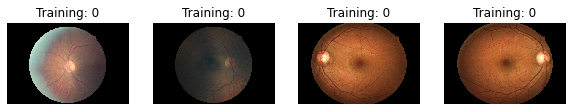

In [70]:
# Code for drawing example images (colored version used since 1d array is not recognized)
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, img_collections, label_list):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

### Creating the model
Here we load  the image list into a SCV model. The data set is divided into a 70% training set and  a 30% test set. 

This ensures that the model is trained on diffrent images then it is tested on.

After training is done i used "predict" to make the model try to predict the correct category on the test set.

In [71]:
# flatten the images
n_samples = len(img_collectionsFlat)
data = img_collectionsFlat
label_list = convertedLabelList

X_train, X_test, y_train, y_test = train_test_split(
    data, label_list, test_size=0.3, shuffle=True
)
if (useExistingModel):
    clf = load("Models/ModelSorted600.joblib")
else:
    # Create a classifier: a support vector classifier
    clf = svm.SVC(gamma=0.001)
    # clf = svm.LinearSVC()
    # clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)

    # Split data into 50% train and 50% test subsets


    # Learn the digits on the train subset
    clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

Here you can see 5 sample images that were predicted on.

Pred stand for what the model thinks is the correct category, Real is what is written in the label list.

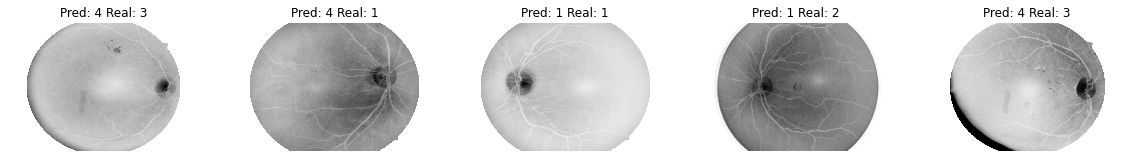

In [72]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
for ax, image, prediction, realCat in zip(axes, X_test, predicted, y_test):
    ax.set_axis_off()
    image = image.reshape(597, 896)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Pred: {prediction} Real: {realCat}")

### Evaluation
Here we run an evaluation matrix showing various performance statistics.

In [73]:
print(
    f"CLassification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

CLassification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       0.27      0.14      0.18        80
           1       0.26      0.21      0.23        89
           2       0.13      0.10      0.11        62
           3       0.39      0.21      0.28        75
           4       0.26      0.65      0.37        69

    accuracy                           0.26       375
   macro avg       0.26      0.26      0.23       375
weighted avg       0.27      0.26      0.24       375




### Save the model
The code below is used to save the model into a file. This allows for the model to be loaded later without having to retrain the model.

In [74]:
# Save the model to a file for later evaluation/testing
# dump(clf, 'Models/ModelSorted160.joblib') 

## Conclusion
The models performance has improved a lot compared to the previous model and is now at least functional for all categories.

However the performance is still too low to be usefull for the stakeholder. 

I have written an analysis document on the model's performance 